In [1]:
# librairies

import xarray as xr
import numpy as np
import pandas as pd

In [4]:
# import data

chemin = r'/Users/fabau/myCloud/Unil/Master/Thesis/Datasets/Curnagl/ERA5_1990_2m_dewpoint_temperature.nc'
#chemin_serveur = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/2m_dewpoint_temperature/ERA5_1990_2m_dewpoint_temperature.nc'
chemin_serveur = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/2m_dewpoint_temperature/ERA5_1990*.nc'
ds = xr.open_mfdataset(chemin_serveur, combine='by_coords')

In [15]:
# tempory : open 5 years 

for i in range(1990,1996):
    for j in range(1,13):
        chemin = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/2m_dewpoint_temperature/ERA5_'+str(i)+'-'+str(j)+'_2m_dewpoint_temperature.nc'
        ds = xr.concat([ds,xr.open_dataset(chemin)],dim='time')

KeyboardInterrupt: 

In [5]:
ds

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1990-01-01 ... 1990-12-31T23:00:00
Data variables:
    2d         (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper03 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Wed Jun 26 09:49:42 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Wed Jun 26 09:50:07 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)

In [37]:
# test to average data on one day, 2 weeks before and 2 weeks after

day = '1990-01-21'
var = 'd2m'

ds_day = ds.sel(time=day)
ds_day

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 8)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1990-01-21 ... 1990-01-21T21:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-13 21:02:30 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
# slice the dataset to only include Europe  71.5, -25, 34.4, 40.5,

ds_day_europe = ds_day.sel(latitude=slice(70, 30), longitude=slice(-10, 40))


In [41]:
# select 2 weeks before and 2 weeks after the day

week_before = pd.to_datetime(day) - pd.DateOffset(days=14)
week_after = pd.to_datetime(day) + pd.DateOffset(days=14)

ds_before = ds.sel(time=slice(week_before, day))
ds_after = ds.sel(time=slice(day, week_after))

ds_combined = xr.concat([ds_before, ds_after], dim='time')

# average data on each longitude and latitude coordinates

ds_combined = ds_combined.mean(dim='time')

ds_combined

# slice the ds_combined to only include Europe

rolled_lon = {'longitude':41, 'longitude':335}
ds_rolled = ds_combined.roll(rolled_lon, roll_coords=True)
ds_combined_europe = ds_rolled.sel(latitude=slice(71, 30), longitude=slice(335, 41))
'''ds_combined_europe_lon = ds_combined.sel(latitude=slice(71, 30), longitude=slice(335, 359.75))
ds_combined_europe = xr.concat([ds_combined_europe, ds_combined_europe_lon], dim='longitude')'''

ds_combined_europe

<xarray.Dataset>
Dimensions:    (longitude: 265, latitude: 165)
Coordinates:
  * longitude  (longitude) float32 335.0 335.2 335.5 335.8 ... 40.5 40.75 41.0
  * latitude   (latitude) float32 71.0 70.75 70.5 70.25 ... 30.5 30.25 30.0
Data variables:
    d2m        (latitude, longitude) float32 254.9 256.8 256.3 ... 273.1 273.3

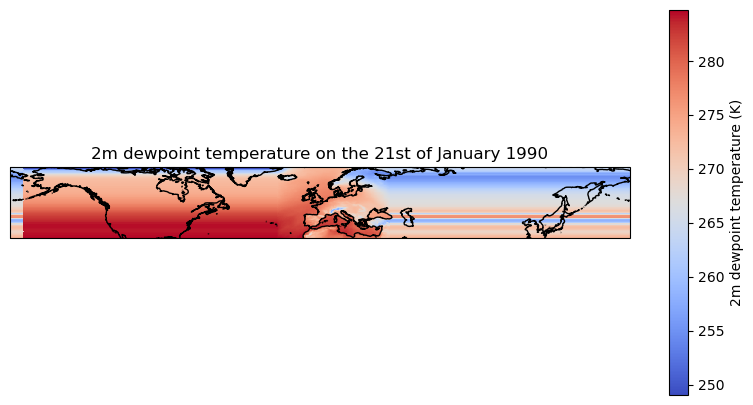

In [7]:
# plot the data on a map using cartopy

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ds_combined_europe_sorted = ds_combined_europe.sortby('longitude')

ds_combined_europe_sorted[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': '2m dewpoint temperature (K)'})
ax.coastlines()
ax.set_title('2m dewpoint temperature on the 21st of January 1990')
plt.show()

In [12]:
# creating the climatology for one variable from each day of a storm

specific_var = list(ds.variables)[0]

# slicing the dataset to only include Europe

rolled_lon = {'longitude':41, 'longitude':335}
ds_rolled = ds.roll(rolled_lon, roll_coords=True)
ds_europe = ds_rolled.sel(latitude=slice(71, 30), longitude=slice(335, 41))

# extract the dates of the storms

for j in range(1990, 1991):

    dates = pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/WS_fabien/storms_start_end.csv', sep=',')
    dates['year'] = dates['start_date'].str[:4]

    length_year = dates[dates['year'] == j].shape[0]
    index_year = dates[dates['year'] == j].index[0]

    # slice the time dimension

    for i in range(index_year,index_year + length_year):
        start_temp = dates['start_date'][i]
        end_temp = dates['end_date'][i]

        # Create a new dataset for each iteration
        new_dataset = xr.Dataset({
            specific_var: ds_europe[specific_var],
            # Add other variables as needed
        })

        # Optionally, you can update the time dimension for the new dataset
        week_before = pd.to_datetime(start_temp) - pd.DateOffset(days=14)
        week_after = pd.to_datetime(end_temp) + pd.DateOffset(days=14)
        new_dataset = new_dataset.sel(time=slice(week_before, week_after))

        # Dynamically name the dataset variable
        locals()[f"v_{specific_var}_{i}"] = new_dataset

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
v_2d_0

NameError: name 'v_2d_0' is not defined

In [42]:
# now iterate through each dataset and calculate the mean



for i in range(index_year,index_year + length_year):
    start_temp = dates['start_date'][i]
    end_temp = dates['end_date'][i]

    locals()[f"{specific_var}_{i}_daily"] = locals()[f"{specific_var}_{i}"].resample(time='1D').mean()
    window_size = 14
    rolling_mean = locals()[f"{specific_var}_{i}_daily"].rolling(time=window_size, center=True).mean()
    locals()[f"{specific_var}_{i}_mean"] = rolling_mean.sel(time=slice(start_temp, end_temp))

In [44]:
d2m_0_mean

<xarray.Dataset>
Dimensions:    (longitude: 265, latitude: 165, time: 7)
Coordinates:
  * longitude  (longitude) float32 335.0 335.2 335.5 335.8 ... 40.5 40.75 41.0
  * latitude   (latitude) float32 71.0 70.75 70.5 70.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 1990-01-22 1990-01-23 ... 1990-01-28
Data variables:
    d2m        (time, latitude, longitude) float32 252.5 254.9 ... 273.4 273.7